# Homework 3 - Uncovering World Events using Twitter Hashtags

## ... and learning about Spark `DataFrames` along the way

In this notebook, we will use temporal information about Twitter hashtags to discover trending topics and potentially uncover world events as they occurred. 

__Hand-in:__

- __Due: 28.04.2020 23:59:59 CET__
- `git push` your final verion to your group's Renku repository before the due
- check if `Dockerfile`, `environment.yml` and `requirements.txt` are properly written
- add necessary comments and discussion to make your codes readable

### Hashtags

The idea here is that when an event is happening and people are having a conversation about it on Twitter, a set of uniform hashtags that represent the event spontaneously evolves. Twitter users then use those hashtags to communicate with one another. Some hashtags, like `#RT` for "retweet" or just `#retweet` are used frequently and don't tell us much about what is going on. But a sudden appearance of a hashtag like `#oscars` probably indicates that the oscars are underway. For a particularly cool example of this type of analysis, check out [this blog post about earthquake detection using Twitter data](https://blog.twitter.com/official/en_us/a/2015/usgs-twitter-data-earthquake-detection.html) (although they search the text and not necessarily hashtags).

In [1]:
%%local
%matplotlib inline
import matplotlib.pylab as plt
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['font.size'] = 18
plt.style.use('fivethirtyeight')

## Initialize the `SparkSession`

In [2]:
spark

Starting Spark application


ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3641,application_1587988164357_0257,pyspark,idle,Link,Link,✔


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

SparkSession available as 'spark'.


FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [3]:
%%info

ID,YARN Application ID,Kind,State,Spark UI,Driver log,Current session?
3552,application_1587988164357_0168,pyspark,idle,Link,Link,
3590,application_1587988164357_0206,pyspark,idle,Link,Link,
3604,application_1587988164357_0220,pyspark,idle,Link,Link,
3609,application_1587988164357_0225,pyspark,idle,Link,Link,
3614,application_1587988164357_0230,pyspark,idle,Link,Link,
3617,application_1587988164357_0233,pyspark,busy,Link,Link,
3618,application_1587988164357_0234,pyspark,idle,Link,Link,
3620,application_1587988164357_0236,pyspark,idle,Link,Link,
3622,application_1587988164357_0238,pyspark,busy,Link,Link,
3625,application_1587988164357_0241,pyspark,idle,Link,Link,


In [4]:
%%help

Magic,Example,Explanation
info,%%info,Outputs session information for the current Livy endpoint.
cleanup,%%cleanup -f,"Deletes all sessions for the current Livy endpoint, including this notebook's session. The force flag is mandatory."
delete,%%delete -f -s 0,Deletes a session by number for the current Livy endpoint. Cannot delete this kernel's session.
logs,%%logs,Outputs the current session's Livy logs.
configure,"%%configure -f{""executorMemory"": ""1000M"", ""executorCores"": 4}",Configure the session creation parameters. The force flag is mandatory if a session has already been created and the session will be dropped and recreated.Look at Livy's POST /sessions Request Body for a list of valid parameters. Parameters must be passed in as a JSON string.
spark,%%spark -o dfdf = spark.read.parquet('...,"Executes spark commands. Parameters: -o VAR_NAME: The Spark dataframe of name VAR_NAME will be available in the %%local Python context as a Pandas dataframe with the same name. -m METHOD: Sample method, either take or sample. -n MAXROWS: The maximum number of rows of a dataframe that will be pulled from Livy to Jupyter. If this number is negative, then the number of rows will be unlimited. -r FRACTION: Fraction used for sampling."
sql,%%sql -o tables -qSHOW TABLES,"Executes a SQL query against the variable sqlContext (Spark v1.x) or spark (Spark v2.x). Parameters: -o VAR_NAME: The result of the SQL query will be available in the %%local Python context as a Pandas dataframe. -q: The magic will return None instead of the dataframe (no visualization). -m, -n, -r are the same as the %%spark parameters above."
local,%%locala = 1,All the code in subsequent lines will be executed locally. Code must be valid Python code.
send_to_spark,%%send_to_spark -o variable -t str -n var,"Sends a variable from local output to spark cluster. Parameters: -i VAR_NAME: Local Pandas DataFrame(or String) of name VAR_NAME will be available in the %%spark context as a Spark dataframe(or String) with the same name. -t TYPE: Specifies the type of variable passed as -i. Available options are: `str` for string and `df` for Pandas DataFrame. Optional, defaults to `str`. -n NAME: Custom name of variable passed as -i. Optional, defaults to -i variable name. -m MAXROWS: Maximum amount of Pandas rows that will be sent to Spark. Defaults to 2500."


## PART I: Set up the hashtag `DataFrame` (10 points / 60)

We have prepared the hashtag data spanning the time from May to July, 2016. This is a significant time in modern European history, e.g. see [Brexit](https://en.wikipedia.org/wiki/Brexit). Lets see if we can see any interesting trends about these events in the Twitter data. 

In [5]:
import pyspark.sql.functions as functions

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### I.a: TODO (1 point/10)

Load the **parquet** data from `/data/twitter/parquet/hashtags` into a Spark dataframe using the appropriate `SparkSession` method. 

Look at the first few rows of the dataset - note the timestamp and its units!

In [6]:
# TODO
df = spark.read.parquet("/data/twitter/parquet/hashtags")

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [7]:
df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp_s: long (nullable = true)
 |-- id: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- hashtag: string (nullable = true)

In [8]:
df.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+------------------+----+-----------------+
|timestamp_s|                id|lang|          hashtag|
+-----------+------------------+----+-----------------+
| 1464768480|737918607980670976|  tr|          lovebts|
| 1464768480|737918607980670976|  tr|            방탄소년단|
| 1464768480|737918607963873281|  ja|          tokyofm|
| 1464768480|737918607976452096|  en|          SotoBot|
| 1464768480|737918607976497152|  en|           Fenton|
| 1464768480|737918607976497152|  en|     vintageglass|
| 1464768480|737918607976497152|  en|        glassbell|
| 1464768480|737918607959719941|  en|          vintage|
| 1464768480|737918607959719941|  en|            1970s|
| 1464768480|737918607959719941|  en|              mod|
| 1464768481|737918612158189568|  ar|        ابن_الغيم|
| 1464768481|737918612158156802|  en|creativitybooster|
| 1464768481|737918612158156802|  en|    growthhacking|
| 1464768481|737918612158156802|  en| entrepreneurship|
| 1464768481|737918612158222336|  en|    jewelry

**The timestamp is in unix time, a system for describing a point in time in the number of seconds that have elapsed since the Unix epoch (00:00:00 UTC on 1 January 1970).**

### User-defined functions

A neat trick of spark dataframes is that you can essentially use something very much like an RDD `map` method but without switching to the RDD. If you are familiar with database languages, this works very much like e.g. a user-defined function in SQL. 

So, for example, if we wanted to make a user-defined python function that returns the hashtags in lowercase, we could do something like this:

In [9]:
@functions.udf
def lowercase(text):
    """Convert text to lowercase"""
    return text.lower()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

The @functions.udf is a "decorator" -- this is really handy python syntactic sugar and in this case is equivalent to:

```python
def lowercase(text):
    return text.lower()
    
lowercase = functions.udf(lowercase)
```

It basically takes our function and adds to its functionality. In this case, it registers our function as a pyspark dataframe user-defined function (UDF).

Using these UDFs is very straightforward and analogous to other Spark dataframe operations. For example:

In [10]:
df.select(lowercase(df.hashtag)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+
|lowercase(hashtag)|
+------------------+
|           lovebts|
|             방탄소년단|
|           tokyofm|
|           sotobot|
|            fenton|
|      vintageglass|
|         glassbell|
|           vintage|
|             1970s|
|               mod|
|         ابن_الغيم|
| creativitybooster|
|     growthhacking|
|  entrepreneurship|
|     jewelryonetsy|
|           jetteam|
|        teenchoice|
|  choicemalehottie|
|        nowplaying|
|              maui|
+------------------+
only showing top 20 rows

Using a framework like Spark is all about understanding the ins and outs of how it functions and knowing what it offers. One of the cool things about the dataframe API is that many functions are already defined for you (turning strings into lowercase being one of them). 

### I.b: TODO (2 points / 10)

Find the [Spark python API documentation](https://spark.apache.org/docs/latest/api/python/index.html). Look for the `sql` section and find the listing of `sql.functions`. Repeat the above (turning hashtags into lowercase) but use the built-in function.

In [11]:
df.select(functions.lower(df.hashtag)).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------------+
|   lower(hashtag)|
+-----------------+
|          lovebts|
|            방탄소년단|
|          tokyofm|
|          sotobot|
|           fenton|
|     vintageglass|
|        glassbell|
|          vintage|
|            1970s|
|              mod|
|        ابن_الغيم|
|creativitybooster|
|    growthhacking|
| entrepreneurship|
|    jewelryonetsy|
|          jetteam|
|       teenchoice|
| choicemalehottie|
|       nowplaying|
|             maui|
+-----------------+
only showing top 20 rows

We'll work with a combination of these built-in functions and user-defined functions for the remainder of this homework. 

### I.c: TODO (3 points/10)

Create `english_df` consisting of **lowercase** hashtags from only english-language tweets. In addition, convert the timestamp to a more readable format like this and name the column `date`:

```
2016-05-01 08:30:00
```

Your `english_df` should look something like this:

```
+-----------+----+------------+-------------------+
|timestamp_s|lang|     hashtag|               date|
+-----------+----+------------+-------------------+
| 1464768480|  en|     sotobot|2016-06-01 10:08:00|
| 1464768480|  en|      fenton|2016-06-01 10:08:00|
| 1464768480|  en|vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|   glassbell|2016-06-01 10:08:00|
| 1464768480|  en|     vintage|2016-06-01 10:08:00|
+-----------+----+------------+-------------------+
```

In [12]:
# English language
english_df = df.filter(df.lang == 'en')

# Select columns,
# apply lowercase to the 'hashtag' column,
# create column 'date' showing the timestamp conversion
english_df = english_df.select('timestamp_s', 
                               'lang',
                               functions.lower(english_df.hashtag).alias('hashtag'),
                               english_df.timestamp_s.cast('timestamp').alias('date')).cache()

english_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----------+----+------------+-------------------+
|timestamp_s|lang|     hashtag|               date|
+-----------+----+------------+-------------------+
| 1464768480|  en|     sotobot|2016-06-01 10:08:00|
| 1464768480|  en|      fenton|2016-06-01 10:08:00|
| 1464768480|  en|vintageglass|2016-06-01 10:08:00|
| 1464768480|  en|   glassbell|2016-06-01 10:08:00|
| 1464768480|  en|     vintage|2016-06-01 10:08:00|
+-----------+----+------------+-------------------+
only showing top 5 rows

**We obtain the expected result after the transformations.**

### I.d: TODO (4 points/10)

We "claim" the data contains all twitters from May to July 2016, however, that's not true. Check which (date, hour) are in `english_df` and which are missing, e.g. 2016-05-01, 10h is in the dataframe while 2016-04-01, 10h not.

**Slack update : Need to show the missing data from 2016.05.01 8h to 2016.08.01 7h**

In [13]:
english_df.printSchema()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

root
 |-- timestamp_s: long (nullable = true)
 |-- lang: string (nullable = true)
 |-- hashtag: string (nullable = true)
 |-- date: timestamp (nullable = true)

In [14]:
import datetime as dt 
import pandas as pd 
import numpy as np 

# Define date range
START_DATE = dt.datetime(2016,5,1,8,0,0)  
END_DATE = dt.datetime(2016,8,1,7,0,0) 

# Generate date range with pandas
timerange = pd.date_range(start=START_DATE, end=END_DATE, freq='H')

# Convert to timestamp
timestamps = [int(x) - 7200 for x in timerange.values.astype(np.int64) // 10 ** 9]   #-7200 because we have a shift of 2 hours 

# Create pyspark dataframe from the above timestamps
timeline = (spark.createDataFrame(timestamps, "int")
    .withColumn('date_hour', functions.from_unixtime('value').cast('timestamp'))
    .drop('value')
    .select(functions.date_format('date_hour', 'yyy-MM-dd HH').alias('date_hour')) )

timeline.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|    date_hour|
+-------------+
|2016-05-01 08|
|2016-05-01 09|
|2016-05-01 10|
|2016-05-01 11|
|2016-05-01 12|
+-------------+
only showing top 5 rows

In [15]:
timeline.agg(functions.max(timeline.date_hour)).collect()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

[Row(max(date_hour)=u'2016-08-01 07')]

In [16]:
# Dataframe with the date as (date, hour) format
date_hour_df = english_df.select(functions.date_format('date', 'yyy-MM-dd HH').alias('date_hour')).distinct().orderBy('date_hour')
date_hour_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|    date_hour|
+-------------+
|2016-05-01 08|
|2016-05-01 09|
|2016-05-01 10|
|2016-05-01 11|
|2016-05-01 12|
+-------------+
only showing top 5 rows

In [17]:
time_not_present = timeline.select('date_hour').subtract(date_hour_df.select('date_hour')).orderBy('date_hour')
time_not_present.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+
|    date_hour|
+-------------+
|2016-05-02 01|
|2016-05-02 02|
|2016-05-02 03|
|2016-05-02 04|
|2016-05-02 08|
|2016-05-02 09|
|2016-05-02 10|
|2016-05-02 11|
|2016-05-02 12|
|2016-05-02 13|
|2016-05-02 14|
|2016-05-27 08|
|2016-05-27 09|
|2016-05-27 10|
|2016-05-27 11|
|2016-05-27 12|
|2016-05-27 13|
|2016-05-27 14|
|2016-05-27 15|
|2016-06-02 08|
+-------------+
only showing top 20 rows

In [18]:
# Dataframe with the countings representing the total number of different hours for each date
date_counts_df = date_hour_df.select(functions.date_format('date_hour', 'yyy-MM-dd').alias('date'))\
                             .groupBy('date')\
                             .count()\
                             .orderBy('date')
date_counts_df.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----------+-----+
|      date|count|
+----------+-----+
|2016-05-01|   16|
|2016-05-02|   13|
|2016-05-03|   24|
|2016-05-04|   24|
|2016-05-05|   24|
+----------+-----+
only showing top 5 rows

**We can easily see the dates that have missing data since they correspond to the ones with count < 24. We can thus see in *date_counts_df* which dates fit this criteria, and then continue the investigation by looking at *date_hour_df*. Since it's a tedious process, we will only tell which (date, hour) are missing.**

**The missing date will be in format:**

**- DATE: MISSING HOURS (expressed either as one missing hour: HOUR, or an interval HOUR1 -> (to) HOUR2)**

**Missing data:**

**- 05-01: 00 -> 07**

**- 05-02: 01 -> 04, 08 -> 14**

**- 05-27: 08 -> 15**

**- 06-02: 08 -> 23**

**- 06-03 -> 06-06: all hours missing**

**- 06-07: 00 -> 19**

**- 06-08: 18 -> 20, 22**

**- 06-16: 15 -> 23**

**- 06-17: all hours missing**

## PART II: Twitter hashtag trends (50 points / 60)

In this section we will try to do a slightly more complicated analysis of the tweets. Our goal is to get an idea of tweet frequency as a function of time for certain hashtags. 

Lets build this up in steps. First, lets see how we can start to organize the tweets by their timestamps. 

As a first easy example, lets say we just want to count the number of tweets per minute over the entire span of our data. For this, we first need a "global" minute value, e.g. "minute of the year" or something similar. 

Spark provides us with some handy built-in dataframe functions that are made for transforming date and time fields. 

Have a look [here](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#module-pyspark.sql.functions) to see the whole list of custom dataframe functions - you will need to use them to complete the next set of TODO items.

Note that the functions can be combined. Consider the following dataframe and its transformation:

In [19]:
from pyspark.sql import Row

# create a sample dataframe with one column "degrees" going from 0 to 180
test_df = spark.createDataFrame(spark.sparkContext.range(180).map(lambda x: Row(degrees=x)), ['degrees'])

# define a function "sin_rad" that first converts degrees to radians and then takes the sine using built-in functions
sin_rad = functions.sin(functions.radians(test_df.degrees))

# show the result
test_df.select(sin_rad).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------------+
|SIN(RADIANS(degrees))|
+---------------------+
|                  0.0|
|  0.01745240643728351|
|  0.03489949670250097|
|  0.05233595624294383|
|   0.0697564737441253|
|  0.08715574274765817|
|  0.10452846326765346|
|  0.12186934340514748|
|  0.13917310096006544|
|  0.15643446504023087|
|  0.17364817766693033|
|   0.1908089953765448|
|  0.20791169081775931|
|  0.22495105434386498|
|  0.24192189559966773|
|  0.25881904510252074|
|  0.27563735581699916|
|   0.2923717047227367|
|   0.3090169943749474|
|   0.3255681544571567|
+---------------------+
only showing top 20 rows

### DataFrames `groupBy`

We used `groupBy` already in the previous notebook, but here we will take more advantage of its features. 

One important thing to note is that unlike other RDD or DataFrame transformations, the `groupBy` does not return another DataFrame, but a `GroupedData` object instead, with its own methods. These methods allow you to do various transformations and aggregations on the data of the grouped rows. 

Conceptually the procedure is a lot like this:

![groupby](https://i.stack.imgur.com/sgCn1.jpg)

The column that is used for the `groupBy` is the `key` - once we have the values of a particular key all together, we can use various aggregation functions on them to generate a transformed dataset. In this example, the aggregation function is a simple `sum`. In the simple procedure below, the `key` will be the hashtag.

### II.a: TODO (1 point / 50)

Calculate the top five most common hashtags in the whole english-language dataset.

This should be your result:

```
+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
```

In [20]:
english_df.groupBy('hashtag').count().orderBy('count', ascending=False).show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+------+
|      hashtag| count|
+-------------+------+
|   mtvhottest|800527|
|veranomtv2016|539028|
|   teenchoice|345208|
|   nowplaying|178561|
|  gameinsight|165237|
+-------------+------+
only showing top 5 rows

**We have the expected top 5 most common hashtags in the dataset.**

## Daily hashtag trends

Now we will start to complicate the analysis a bit. Remember, our goal is to uncover trending topics on a timescale of a few days. A much needed column then is simply `day`. To convert the date string into day-of-year, you can use the built-in [dayofyear](http://spark.apache.org/docs/latest/api/python/pyspark.sql.html#pyspark.sql.functions.dayofyear) function. 

In the subsequent sections we will then not only see which hashtags are globally most popular, but which ones experience the biggest changes in popularity - those are the "trending" topics. If there is suddenly a substantial increase of a hashtag over a matter of a day or two, it may signify an event taking place. 

### II.b: TODO (2 points / 50)

Create a dataframe called `daily_hashtag` that includes the columns `month`, `week`, `day` and `hashtag`. Use the `english_df` you made above to start, and make sure you find the appropriate spark dataframe functions to make your life easier. Show the result.

Try to match this view:

```
+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
```

In [21]:
daily_hashtag = english_df.select(functions.month(english_df.date).alias('month'),\
                                  functions.weekofyear(english_df.date).alias('week'),\
                                  functions.dayofyear(english_df.date).alias('day'),\
                                  'hashtag')
daily_hashtag.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-----+----+---+------------+
|month|week|day|     hashtag|
+-----+----+---+------------+
|    6|  22|153|     sotobot|
|    6|  22|153|      fenton|
|    6|  22|153|vintageglass|
|    6|  22|153|   glassbell|
|    6|  22|153|     vintage|
+-----+----+---+------------+
only showing top 5 rows

**Again, the results are matching the expected view.**

### II.c: TODO (2 points / 50)

Now we want to calculate the number of times a hashtag is used per day. Sort in descending order of daily counts and show the result. Call the resulting dataframe `day_counts`.

Your output should look like this:

```
+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
```

<div class="alert alert-info">
<p>Make sure you use `cache()` when you create `day_counts` because we will need it in the steps that follow!</p>
</div>

In [22]:
day_counts = daily_hashtag.groupBy(['day', 'hashtag', 'week']).count().orderBy('count', ascending=False).cache()
day_counts.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
only showing top 5 rows

### II.d: TODO (2 points / 50)

To get an idea of which hashtags stay popular for several days, calculate the average number of daily occurences for each week. 

__Hint:__ use the `week` column we created above. Sort in descending order and show the top 20.

In [23]:
day_counts.groupBy(['hashtag', 'week']).agg(functions.mean('count')).orderBy('avg(count)', ascending=False).show(20)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+----+------------------+
|            hashtag|week|        avg(count)|
+-------------------+----+------------------+
|         mtvhottest|  29| 52061.42857142857|
|         mtvhottest|  30|           47927.0|
|         teenchoice|  19|20068.571428571428|
|      veranomtv2016|  25| 17867.85714285714|
|      veranomtv2016|  26| 17116.14285714286|
|      veranomtv2016|  27| 14476.57142857143|
|         mtvhottest|  31|           14062.0|
|      veranomtv2016|  30|12510.285714285714|
|         mtvhottest|  28|12287.714285714286|
|      mtvawardsstar|  23|12191.833333333334|
|       ripchristina|  23|           11963.5|
|      altonsterling|  27|           10266.2|
|       demsinphilly|  30|10063.714285714286|
|aldub1stanniversary|  28|           8413.25|
|      veranomtv2016|  29| 8323.857142857143|
|           rncincle|  29| 8195.285714285714|
| pushawardslizquens|  30|            8148.0|
|       1dreamboy2ff|  25|            7219.0|
|             brexit|  25| 7021.71

**We find in the top of list some hashtags about tv shows where the viewers vote by tweeting. We also find hashtags referring to major events that happened at that period like the death of a famous singer, the democratic presidential race and mass shooting incidents. The Brexit arrives only at the 19th position with an average of 7021 tweets per day during week 25.**

### Using `Window` functions 

Window functions are another awesome feature of dataframes. They allow users to accomplish complex tasks using very concise and simple code. 

Above we computed just the hashtag that had the most occurrences on *any* day. Now lets say we want to know the top tweets for *each* day.  

This is a non-trivial thing to compute and requires "windowing" our data. I recommend reading this [window functions article](https://databricks.com/blog/2015/07/15/introducing-window-functions-in-spark-sql.html) to get acquainted with the idea. You can think of a window function as a fine-grained and more flexible `groupBy`. 

There are two things we need to define to use window functions:

1. the "window" to use, based on which columns (partitioning) and how the rows should be ordered 
2. the computation to carry out for each windowed group, e.g. a max, an average etc.

Lets see how this works by example. We will define a window function, `daily_window` that will partition data based on the `day` column. Within each window, the rows will be ordered by the daily hashtag count that we computed above. Finally, we will use the rank function **over** this window to give us the ranking of top tweets. 

In the end, this is a fairly complicated operation achieved in just a few lines of code! (can you think of how to do this with an RDD??)

In [24]:
from pyspark.sql import Window

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

First, we specify the window function and the ordering:

In [25]:
daily_window = Window.partitionBy('day').orderBy(functions.desc('count'))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [26]:
day_counts.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
only showing top 5 rows

The above window function says that we should window the data on the `day` column and order it by count. 

Now we need to define what we want to compute on the windowed data. We will start by just calculating the daily ranking of hashtags, so we can use the helpful built-in `functions.rank()` and sort:

In [27]:
daily_rank = functions.rank().over(daily_window)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

### II.e: TODO (3 points / 50)
Now compute the top five hashtags for each day in our data:

In [28]:
daily_ranked = day_counts.select("count","hashtag","day", daily_rank.alias("daily_rank"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [29]:
daily_ranked.filter(functions.col('daily_rank') <= 5).groupBy("day")\
            .agg(functions.concat_ws(", ", functions.collect_list(daily_ranked.hashtag)).alias("TOP 5")).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+--------------------+
|day|               TOP 5|
+---+--------------------+
|148|dolceamoresatotoo...|
|137|aldub10thmonthsar...|
|133|teenchoice, dolce...|
|193|teenchoice, euro2...|
|211|mtvhottest, veran...|
|126|aldub42ndweeksary...|
|183|veranomtv2016, gr...|
|210|mtvhottest, demsi...|
|159|mtvawardsstar, it...|
|192|teenchoice, euro2...|
|128|화양연화onstageepilog...|
|209|mtvhottest, savem...|
|122|aldubkiligsasweet...|
|190|dallas, veranomtv...|
|140|aldub44thweeksary...|
|177|veranomtv2016, 1d...|
|132|teenchoice, dolce...|
|152|aldubhomeatlast, ...|
|185|veranomtv2016, eu...|
|146|aldubsoclose, dol...|
+---+--------------------+
only showing top 20 rows

## II.f: TODO - Compute the top five trending tweets per week (20 points / 50)

Use window functions (or other techniques!) to produce lists of top few trending tweets for each week. What's a "trending" tweet? Something that seems to be suddenly growing very rapidly in popularity. You should identify "brexit" in week 25 and other events like the death of The Artist Formerly Known as Prince, the Met gala, Euro 2016, the terrorist attacks in Nice, France etc. Make it as simple or as complicated as you want! The final listing should be clear and concise and the flow of your analysis should be easy to follow. If you make an implementation that is not immediately obvious, make sure you provide comments either in markdown cells or in comments in the code itself. 


**We first need to compute for each week the observed distribution of the hashtags.**

In [30]:
count_week = day_counts.groupBy(['hashtag', 'week']).agg(functions.sum('count').alias('weekly_count'))
count_week.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+------------+
|             hashtag|week|weekly_count|
+--------------------+----+------------+
|6yearsofonedirection|  29|       10137|
|       aldubtrumpets|  23|        6036|
|           mtvpopcd9|  23|        4972|
|           rajaviyes|  27|        2507|
|            monacogp|  21|        3995|
+--------------------+----+------------+
only showing top 5 rows

In [31]:
total_week = day_counts.groupBy('week').agg(functions.sum('count').alias('week_total'))
total_week.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+----------+
|week|week_total|
+----+----------+
|  31|    192303|
|  28|   3479762|
|  26|   3407916|
|  27|   3611600|
|  22|   1413258|
+----+----------+
only showing top 5 rows

In [32]:
joined_week = count_week.join(total_week, on='week', how='left_outer')
joined_week.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+------------+----------+
|week|             hashtag|weekly_count|week_total|
+----+--------------------+------------+----------+
|  31|               video|         190|    192303|
|  31|christinagrimmied...|         124|    192303|
|  31|          applemusic|          12|    192303|
|  31|        airbnbexpert|           1|    192303|
|  31|                 mic|           1|    192303|
+----+--------------------+------------+----------+
only showing top 5 rows

**We now have the weekly appearance of each hashtag, but we need to normalize it with the total count for that week to make everything homogeneous.**

In [33]:
norm_weekly_count = joined_week.select("hashtag","week",(joined_week.weekly_count/joined_week.week_total).alias('normalized_count'))
norm_weekly_count.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+--------------------+
|             hashtag|week|    normalized_count|
+--------------------+----+--------------------+
|               video|  31|  9.8802410778823E-4|
|christinagrimmied...|  31|6.448157335038975E-4|
|          applemusic|  31|6.240152259715137E-5|
|        airbnbexpert|  31|5.200126883095947...|
|                 mic|  31|5.200126883095947...|
+--------------------+----+--------------------+
only showing top 5 rows

In [34]:
norm_weekly_count.groupby('week').sum().show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+---------+---------------------+
|week|sum(week)|sum(normalized_count)|
+----+---------+---------------------+
|  31|  1156083|    1.000000000000125|
|  28| 10609704|   0.9999999999989013|
|  26|  9923992|   1.0000000000012494|
|  27| 10127214|   1.0000000000055527|
|  22|  4804910|    1.000000000002735|
+----+---------+---------------------+
only showing top 5 rows

**For each week we have the observed multinomial distribution of the hashtags. Now we need to compute the prior distribution, that is for each hashtag we will have an expected probability computed by taking the average of the weekly probabilities corresponding to this hashtag during the previous weeks.**

In [35]:
# For each hashtag we order its weekly count by order of appearance and select the previous weeks
# We select the last known weeks  
window_size = 2  # number of weeks from which we construct the prior
hashtag_week_window = Window.partitionBy('hashtag').orderBy('week').rangeBetween(-window_size,-1) 

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [36]:
norm_weekly_count_prior = norm_weekly_count.withColumn('prior', functions.avg('normalized_count').over(hashtag_week_window))
norm_weekly_count_prior.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----+--------------------+--------------------+
|     hashtag|week|    normalized_count|               prior|
+------------+----+--------------------+--------------------+
|         08n|  27|2.768855908738509...|                null|
|100daysoffit|  28|2.873759757132815...|                null|
|     100daze|  20|3.203183708351404...|                null|
|    100pac12|  18|6.578495096883142E-7|                null|
|    100pac12|  19|2.844794822018256...|6.578495096883142E-7|
+------------+----+--------------------+--------------------+
only showing top 5 rows

**We have prior that are null because the first week that we enconter a hastag we don't have a prior distribution yet.**

**Now that we established a baseline of expected frequencies based on history we would like to compare it with the observed frequencies.**

**We assume that hashtags are drawn independently at random from a static distribtuion where each one has a prior likelihhod of being selected (the estimated prior). 
We then observe samples, the tweets of the current week and we ask ourselves what is the probability that they were drawn form the estimated distrbution ?**

**To accomplish this goodness of fit test, we use the chi-squared test. 
The chi square value is a good estimator of trendiness**

**For each hashtag we have O = observed normalized count and  E = expected normalized count**

$\tilde{\chi}^2=\frac{(O - E)^2}{E}\ $ if Observed > Expected 

$\tilde{\chi}^2= 0 $ otherwise 

**To handle the problem of null prior we add one smoothing.**

$\tilde{\chi}^2 =\frac{( (O+1) - (E+1) )^2}{E+1} = \frac{ (O - E )^2}{E+1}$

In [37]:
norm_weekly_count_prior = norm_weekly_count_prior.withColumn('prior', 100 * norm_weekly_count_prior.prior)\
                            .withColumn('normalized_count', 100 * norm_weekly_count_prior.normalized_count)

norm_weekly_count_prior = norm_weekly_count_prior.fillna({'prior': 0})
norm_weekly_count_prior.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----+--------------------+--------------------+
|     hashtag|week|    normalized_count|               prior|
+------------+----+--------------------+--------------------+
|         08n|  27|2.768855908738509...|                 0.0|
|100daysoffit|  28|2.873759757132815...|                 0.0|
|     100daze|  20|3.203183708351405E-5|                 0.0|
|    100pac12|  18|6.578495096883142E-5|                 0.0|
|    100pac12|  19|2.844794822018256...|6.578495096883142E-5|
+------------+----+--------------------+--------------------+
only showing top 5 rows

In [38]:
chi_score_dt = norm_weekly_count_prior.filter(functions.col('normalized_count') > functions.col('prior'))\
                       .withColumn('Chi-score', ((norm_weekly_count_prior.normalized_count - norm_weekly_count_prior.prior)**2) / (norm_weekly_count_prior.prior+ 1))
chi_score_dt.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------+----+--------------------+--------------------+--------------------+
|     hashtag|week|    normalized_count|               prior|           Chi-score|
+------------+----+--------------------+--------------------+--------------------+
|         08n|  27|2.768855908738509...|                 0.0|7.666563043356158...|
|100daysoffit|  28|2.873759757132815...|                 0.0|8.258495141716058...|
|     100daze|  20|3.203183708351405E-5|                 0.0|1.026038586944785...|
|    100pac12|  18|6.578495096883142E-5|                 0.0|4.327659773971554E-9|
|    100pac12|  20| 6.40636741670281E-5|4.711644959450699E-5|2.871948891079468...|
+------------+----+--------------------+--------------------+--------------------+
only showing top 5 rows

In [39]:
chi_score_dt.orderBy('Chi-score', ascending=False).show(40)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+----+------------------+--------------------+-------------------+
|             hashtag|week|  normalized_count|               prior|          Chi-score|
+--------------------+----+------------------+--------------------+-------------------+
|          mtvhottest|  29| 9.336614372437221|  1.2383129191111688|  29.29996332013559|
|          teenchoice|  19|3.9963677659712467|  2.3024732839091E-4| 15.965439068213039|
|       veranomtv2016|  25|3.4577573053848676|0.012906023296159003|  11.71579601934945|
|       mtvawardsstar|  23| 3.096537851324191|3.409369082613786E-5|  9.588008630435665|
|          mtvhottest|  28|  2.47183571750022|0.003202005133171...|  6.074701181469566|
|          teenchoice|  31|3.3405615097008368|  0.4355134277465429|   5.87894490942817|
|        demsinphilly|  30|1.7632592989363527|0.021403839933280554|  2.970480745653935|
|dolceamorethegame...|  31| 1.623479612902555| 0.05894551357060884|  2.311513592157272|
|            rncincle|  29|1.469

**For each week we then take the top 5.**

In [40]:
weekly_window = Window.partitionBy('week').orderBy(functions.desc('Chi-score'))
weekly_rank = functions.rank().over(weekly_window)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [41]:
weekly_ranked = chi_score_dt.select("Chi-score","hashtag","week", weekly_rank.alias("weekly_rank"))
weekly_ranked.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+------------------+--------------------+----+-----------+
|         Chi-score|             hashtag|week|weekly_rank|
+------------------+--------------------+----+-----------+
|  5.87894490942817|          teenchoice|  31|          1|
| 2.311513592157272|dolceamorethegame...|  31|          2|
|1.2723977908133293|   choicemalewebstar|  31|          3|
|0.9640899858788207|   aldublolalifeanew|  31|          4|
|0.7537497829552875|    teenchoiceawards|  31|          5|
+------------------+--------------------+----+-----------+
only showing top 5 rows

In [42]:
top5_per_week = weekly_ranked.filter(functions.col('weekly_rank') <= 5).groupBy("week")\
            .agg(functions.concat_ws(", ", functions.collect_list(weekly_ranked.hashtag)).alias("TOP5"))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [43]:
top5_per_week.show(10)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+----+--------------------+
|week|                TOP5|
+----+--------------------+
|  31|teenchoice, dolce...|
|  28|mtvhottest, aldub...|
|  26|veranomtv2016, be...|
|  27|altonsterling, bl...|
|  22|teenchoice, dolce...|
|  20|1dreamboy2today, ...|
|  19|teenchoice, eurov...|
|  17|aldubkiligsasweet...|
|  23|mtvawardsstar, ri...|
|  25|veranomtv2016, br...|
+----+--------------------+
only showing top 10 rows

**This final top 5 hashtags per week seems to faithfully highlight the trending hashtags per week. We indeed have the brexit event appearing in week 25 and we don't have the problem of having the same event trending on several weeks. Indeed, by computing a prior disitribution and using the chi-score criterion we observe that the hashtags corresponding to tv shows that were occupying the trends for consecutive weeks are only now occupying it for one (or maximum 2) weeks.**



## Plotting the timeseries of hashtag counts and using KMeans clustering

### II.g: TODO (8 points / 50)

The lists we obtained above are nice, but lets actually visualize some data. 

1. create a matrix that consists of hashtags as rows and daily counts as columns (hint: use `groupBy` and methods of `GroupedData`). 
2. use the `VectorAssembler` from the Spark ML library to create the feature vector which will consist of daily counts. 

If you extract any of these vectors you will obtain an array that represents the time series of daily counts - plot this time series for a few interesting hashtags you identified above. 

__Hint__: `isin` method of DataFrame columns might be useful. 

In [44]:
hashtags = day_counts.groupBy('hashtag').count()
hashtags.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+-----+
|             hashtag|count|
+--------------------+-----+
|     aldubseeyousoon|   13|
|onedirectionisove...|   13|
|    themaineaudition|   12|
|   3yearswithoutcory|   12|
|              travel|   88|
+--------------------+-----+
only showing top 5 rows

In [45]:
# 1. Matrix with hashtags as rows and daily counts as columns
matrix = day_counts.groupBy('hashtag').pivot('day').sum("count").fillna(0)
matrix.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---------------+---+---+----+----+----+---+---+---+---+---+---+---+---+---+---+---+----+----+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+---+----+---+
|        hashtag|122|123| 124| 125| 126|127|128|129|130|131|132|133|134|135|136|137| 138| 139|140|141|142|143|144|145| 146|147|148|149|150|151|152|153|154|159|160|161|162|163|164|165|166|167|168|170|171| 172| 173| 174| 175| 176| 177| 178| 179| 180| 181| 182| 183| 184| 185| 186| 187| 188| 189| 190|191| 192| 193| 194| 195| 196| 197| 198| 199| 200| 201| 202| 203| 204| 205| 206| 207| 208| 209| 210| 211|212| 213|214|
+---------------+---+---+----+----+----+---+---+---+---+---+---+---+---+---+---+---+----+----+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+-

In [46]:
from pyspark.ml.feature import VectorAssembler

# 2. Create the feature vector
assembler = VectorAssembler(inputCols = matrix.columns[1:], outputCol = "features")

output = assembler.transform(matrix)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [47]:
output.select('features').show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|            features|
+--------------------+
|[390.0,587.0,1196...|
|[88.0,106.0,163.0...|
|(88,[58,78],[1.0,...|
|(88,[2,3,7,14,15,...|
|(88,[0,2,4,5,6,7,...|
|(88,[37,68],[1.0,...|
|(88,[20,21],[1.0,...|
|      (88,[6],[1.0])|
|     (88,[73],[1.0])|
|(88,[46,60],[1.0,...|
|     (88,[61],[1.0])|
|     (88,[41],[1.0])|
|(88,[21,51,81],[1...|
|(88,[0,2,3,4,6,7,...|
|(88,[2,7,10,11,12...|
|(88,[0,1,2,3,9,11...|
|(88,[45,49,51,74,...|
|(88,[7,80],[1.0,1...|
|(88,[2,4,5,8,10,1...|
|(88,[19,63,66,71]...|
+--------------------+
only showing top 20 rows

**We will try to take different types of events to make the analysis more diverse. The following lists consists for instance in tv shows, a sport event or the brexit. We also only take 6 events to make the results more clear.**

In [48]:
hashtag_list = ["brexit","mtvhottest","veranomtv2016","euro2016","altonsterling","metgala"]

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [49]:
from pyspark.sql.types import *
vector_udf = functions.udf(lambda vector: vector.toArray().tolist(), ArrayType(DoubleType()))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [50]:
vector = output.filter(output.hashtag.isin(hashtag_list)).select("hashtag",vector_udf("features").alias('features'))
vector.show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------+--------------------+
|      hashtag|            features|
+-------------+--------------------+
|     euro2016|[14.0, 20.0, 26.0...|
|      metgala|[54.0, 377.0, 210...|
|veranomtv2016|[0.0, 0.0, 0.0, 0...|
|   mtvhottest|[3.0, 3.0, 8.0, 1...|
|altonsterling|[0.0, 0.0, 0.0, 0...|
|       brexit|[171.0, 107.0, 18...|
+-------------+--------------------+

In [51]:
import datetime

x_label = []
for day in matrix.columns[1:]:
    x_label.append(datetime.datetime(2016, 1, 1) + datetime.timedelta(int(day) - 1))

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [52]:
%%spark -o vector

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

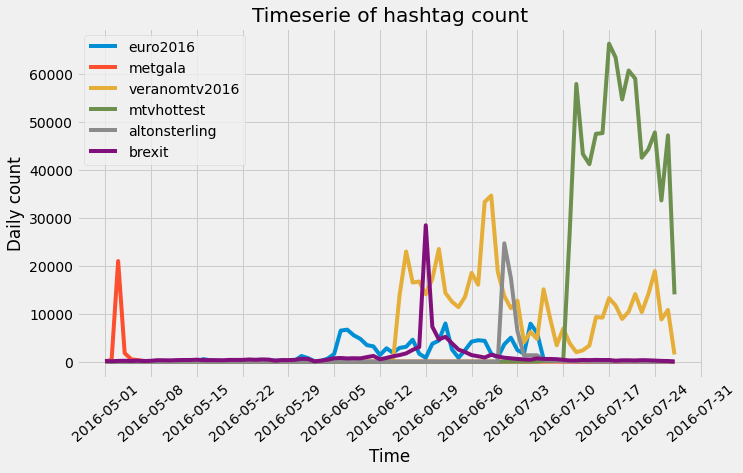

In [53]:
%%local

import pandas as pd 
for i in range(len(vector)):
    plt.plot(vector['features'][i],label = vector['hashtag'][i])

x_label = pd.date_range(start="2016-05-01",end="2016-08-01").map(lambda x: x.strftime('%Y-%m-%d'))
plt.xticks(range(len(x_label))[::7], x_label[::7], rotation=40,)

plt.legend(loc="best")
plt.title("Timeserie of hashtag count")
plt.xlabel('Time')
plt.ylabel('Daily count')
plt.show()

**We can clearly see that we have two types of events. Some of them happen during one specific day like the shooting of Alton Sterling or the Met Gala, which creates a sudden peak of hashtags for a relatively short period of time. On the other hand, other events happen during a few weeks like the Euro 2016 or the TV shows which makes the corresponding hashtags stay popular for a longer period of time.**

**We can also see that the number of hashtags for MTV Hottest is clearly larger than the other events we selected. This is due to the fact that viewers have to use the hashtags to vote, which directly increases the popularity of the hashtag.**

### II.h: TODO - Use KMeans to cluster hashtags based on the daily count timeseries (12 points / 50)

Use the DataFrame you created above to cluster the hashtag timeseries. Train the model and calculate the cluster membership for all hashtags. 

Show the cluster that includes "brexit" - does it make sense?

Again, be creative and see if you can get the clustering to give you meaningful hashtag groupings. Make sure you document your process and code and make your final notebook easy to understand even if the result is not optimal or complete. 

__Hint:__ Additional data cleaning or filtering might be necessary to get useful results from the model. 

In [54]:
matrix.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

2421020

In [55]:
day_counts.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+---+----------+----+-----+
|day|   hashtag|week|count|
+---+----------+----+-----+
|204|mtvhottest|  29|66372|
|205|mtvhottest|  29|63495|
|207|mtvhottest|  30|60768|
|208|mtvhottest|  30|59065|
|199|mtvhottest|  28|57956|
+---+----------+----+-----+
only showing top 5 rows

In [56]:
distribution = day_counts.select('count')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [57]:
%%spark -o distribution

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

**We want to remove the outliers so we compute the distribution.**

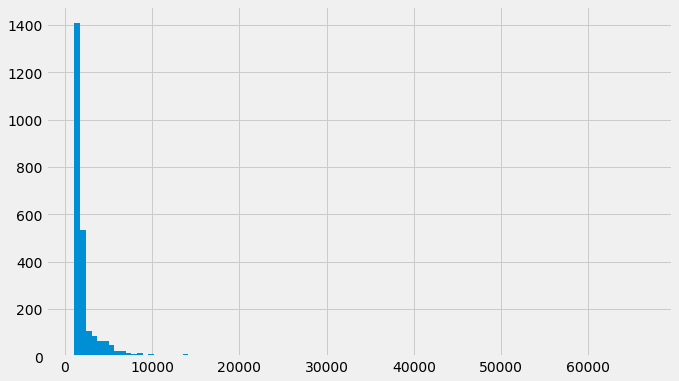

Output()

In [58]:
%%local

import matplotlib.pyplot as plt

plt.hist(distribution['count'],bins=100)
plt.show()
distribution.quantile([0.05, 0.5,0.75,0.8,0.9,0.95])

In [59]:
min_max_threshold = 150 # ensures that it has some peak and it's not just a noise

top_count = day_counts.groupby("hashtag").agg(functions.max("count").alias("max_count"))

# Number of hashtags we week for analysis
big_hashtags = top_count.filter(top_count.max_count > min_max_threshold).select("hashtag")
big_hashtags.count()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

5090

In [60]:
truncated_matrix = matrix.join(big_hashtags, on='hashtag', how='right')
truncated_matrix.show(5)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+
|            hashtag|122|123|124|125|126|127|128|129|130|131|132|133|134|135|136|137|138|139|140|141|142|143| 144|145|146|147|148|149|150|151|152|153|154|159|160|161|162|163|164|165|166|167|168|170|171|172|173|174|175|176|177|178|179|180|181|182|183|184|185|186|187|188|189|190|191|192|193|194| 195|196|197|198|199|200|201|202|203|204|205|206|207|208|209|210|211|212|213|214|
+-------------------+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+----+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+---+--

In [61]:
from pyspark.ml.pipeline import Pipeline
from pyspark.ml.feature import Normalizer
from pyspark.ml.feature import PCA 

# Pipeline
assembler = VectorAssembler(inputCols = truncated_matrix.columns[1:], outputCol="features") # feature vector
normalizer = Normalizer(inputCol="features", outputCol="normFeatures", p=1.0) # normalize the data 
pca = PCA(k = 20, inputCol="normFeatures", outputCol="pca") # reduce dimensions with PCA

pipeline = Pipeline(stages=[assembler,normalizer,pca])

data = pipeline.fit(truncated_matrix).transform(truncated_matrix)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [62]:
from pyspark.ml.clustering import KMeans
from pyspark.sql import Row

# Find the best number of clusters k
def computation_k(data,k_max,step,input_col):
    cost = []
    
    for k in range(2,k_max,step):
        kmeans = KMeans()\
                .setK(k)\
                .setSeed(1)\
                .setFeaturesCol(input_col)\
                .setPredictionCol("cluster")
        
        model = kmeans.fit(data)
        cost.append(Row(cost=model.computeCost(data)))
        
    return spark.createDataFrame(cost)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [63]:
cost_dt = computation_k(data, 100, 10, 'pca')

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [64]:
%%spark -o cost_dt

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

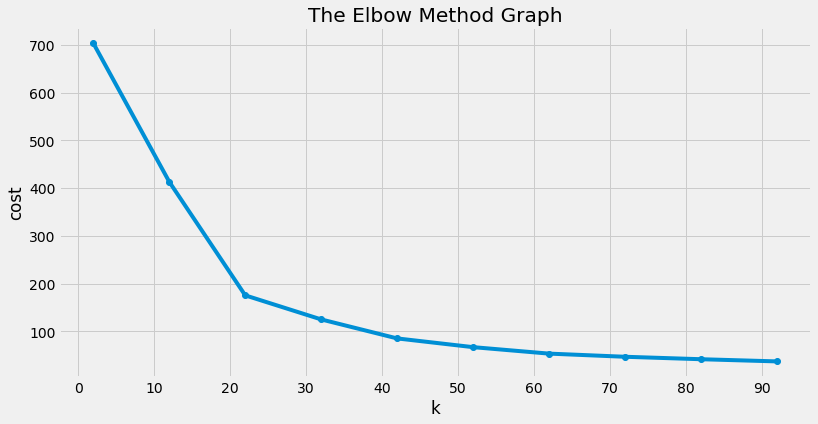

In [65]:
%local

from matplotlib.ticker import MaxNLocator

fig, ax = plt.subplots(1,1, figsize =(12,6))
ax.plot(range(2,100,10),cost_dt, marker='o')
ax.set_xlabel('k')
ax.set_ylabel('cost')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
plt.title('The Elbow Method Graph')
plt.show()

**We see with this elbow method graph that the best number of clusters is probably between 20 and 40. After trying a few values, we find that k=42 gives interesting results.**

In [66]:
from pyspark.ml.clustering import KMeans
k = 42

kmeans = KMeans()\
            .setK(k)\
            .setSeed(1) \
            .setFeaturesCol("pca")\
            .setPredictionCol("cluster")

model = kmeans.fit(data)

predictions = model.transform(data)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

In [67]:
# Number of hashtags per cluster
predictions.groupby('cluster').count().orderBy('count',ascending=False).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
|cluster|count|
+-------+-----+
|      1| 1096|
|     22|  257|
|     20|  250|
|     39|  182|
|     38|  172|
|     41|  151|
|     32|  144|
|      5|  132|
|     25|  118|
|     31|  117|
|     27|  117|
|      4|  114|
|      9|  111|
|     18|  108|
|      6|  101|
|     10|  101|
|      7|   98|
|      8|   96|
|     35|   94|
|      2|   93|
+-------+-----+
only showing top 20 rows

In [68]:
# Cluster in which #brexit appears and the number of hashtags in that cluster
brexit_cluster = predictions.filter(predictions.hashtag == 'brexit').select("cluster").collect()[0]['cluster']
predictions.groupby('cluster').count().orderBy('count',ascending=False).filter(predictions.cluster == brexit_cluster).show()

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+-------+-----+
|cluster|count|
+-------+-----+
|      8|   96|
+-------+-----+

In [69]:
predictions.filter(predictions.cluster == brexit_cluster).select('hashtag').show(100)

FloatProgress(value=0.0, bar_style='info', description='Progress:', layout=Layout(height='25px', width='50%'),…

+--------------------+
|             hashtag|
+--------------------+
|        nbadraft2016|
|mondaynanamanbuka...|
|               leave|
|beckywiththebadgr...|
|             perfect|
|               euref|
|      whathavewedone|
|     thankyoumcirene|
|takeyourdogtoworkday|
|         mtvmusicevo|
|            nbadraft|
|              remain|
|dogsatpollingstat...|
|                gawa|
|          vidcon2016|
|       msgproducts4u|
|bestbreakthrougha...|
|      flyinsingapore|
|                 esp|
|            cd9video|
|  5thhinduadhiveshan|
|                 cd9|
|             ges2016|
|  alduboverloadkilig|
|     bigasspoolparty|
|                 nir|
| failedmodidiplomacy|
|              knicks|
|          voteremain|
|          brexitvote|
|       bfysongforyou|
|                 isl|
|         copaamerica|
|         eurefresult|
|       bbcreferendum|
|                 cro|
|             flyinsg|
|        saturnawards|
|              coybig|
|          ifeelalive|
|     happy

**These are the final hashtags that are part of the #brexit cluster. Let's first note that we started with over 2 million hashtags, reducing them to approximately 5000 after preprocesing. 
The preprocessing has been in 3 main steps:**
* **Filtering : By keeping only the hashtags that have a maximum daily count of at least 150.**
* **Normalization : We normalized that feature vector to have a p1 norm of 1 such that each one models a distribution.**
* **PCA : We reduced the vector dimensionality in such a way that the variance of the data in the low-dimensional    representation is maximized.**

**Let's now take a look at the hashtags in this cluster. These are the hashtags that are directly directed to the brexit (in the order found in the previous dataframe): leave, euref, remain, voteremain, brexitvote, eurefresult, bbcreferendum, brexitornot, notmyvote, eurefresults, ivoted, ukreferendum, brexit, ivotedleave, brexitfail, eureferendum, stormzyforprimeminister, referendum.**

**We thus have almost 19% of the hashtags in the cluster that are related to the brexit which seems to be a pretty good result. We still have many other different hashtags that could correspond to an event happening at the same time like the Glastonbury festival or the American football cup with a few different Messi hashtags. Some other hashtags seem more general and could be used for many contexts which may have led to their appearance (rosé, irl, smilemore...). All these hashtags that are not related to brexit could maybe be removed with another tuning of the parameters but finding the best set of parameters could take a lot of time. Another way to improve the results could be by trying other methods than K-means.**